In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import splitfolders
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Splitting the Data Into Train, Validation and Test Sets
splitfolders.ratio("data",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 4188 files [00:20, 201.92 files/s]


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

In [ ]:
train = datasets.ImageFolder(root="splitted_data/train",
                              transform=train_transform)

val = datasets.ImageFolder(root="splitted_data/val",
                            transform=val_transform)

test = datasets.ImageFolder(root="splitted_data/test",
                             transform=test_transform)

data = datasets.ImageFolder(root="data",
                            transform=data_transform)


In [8]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 

Images per Class in TRAIN:
1    914
3    813
0    802
2    401
dtype: int64 

Images per Class in VALIDATION:
1    261
3    232
0    229
2    114
dtype: int64 

Images per Class in TEST:
1    131
3    117
0    115
2     59
dtype: int64 



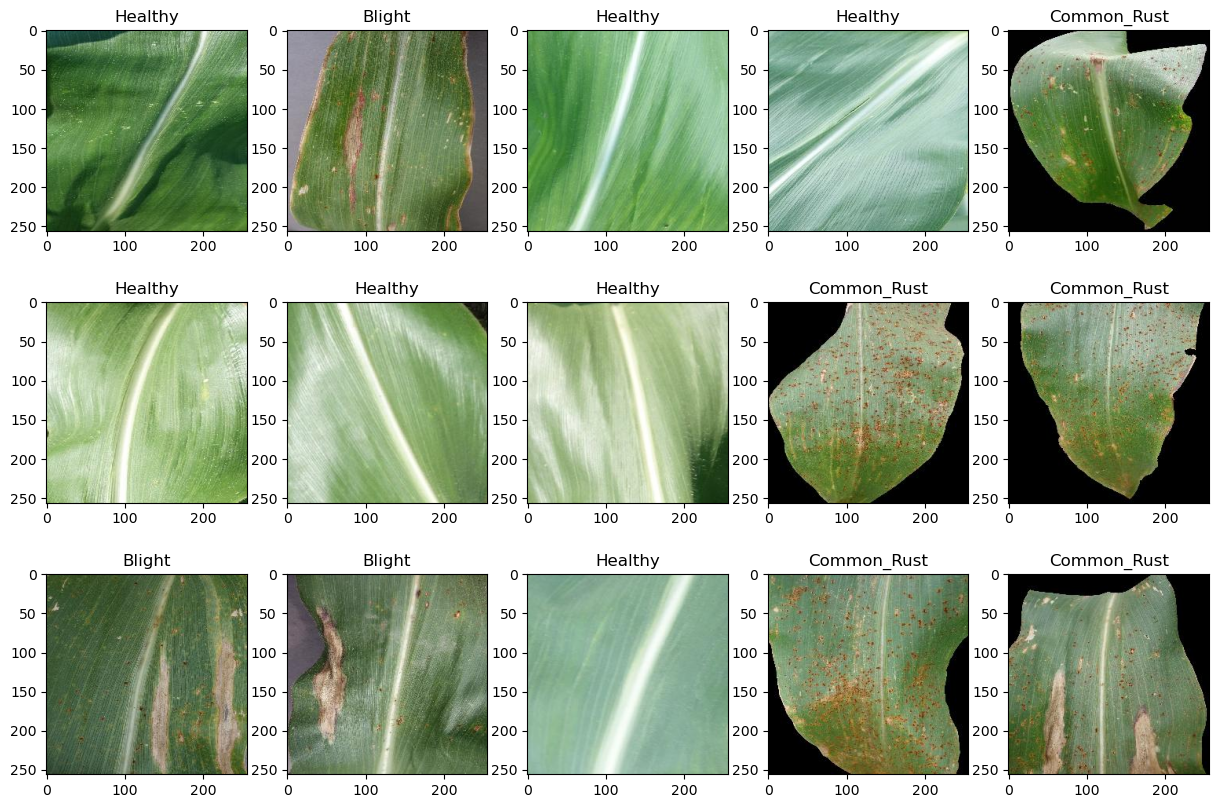

In [9]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

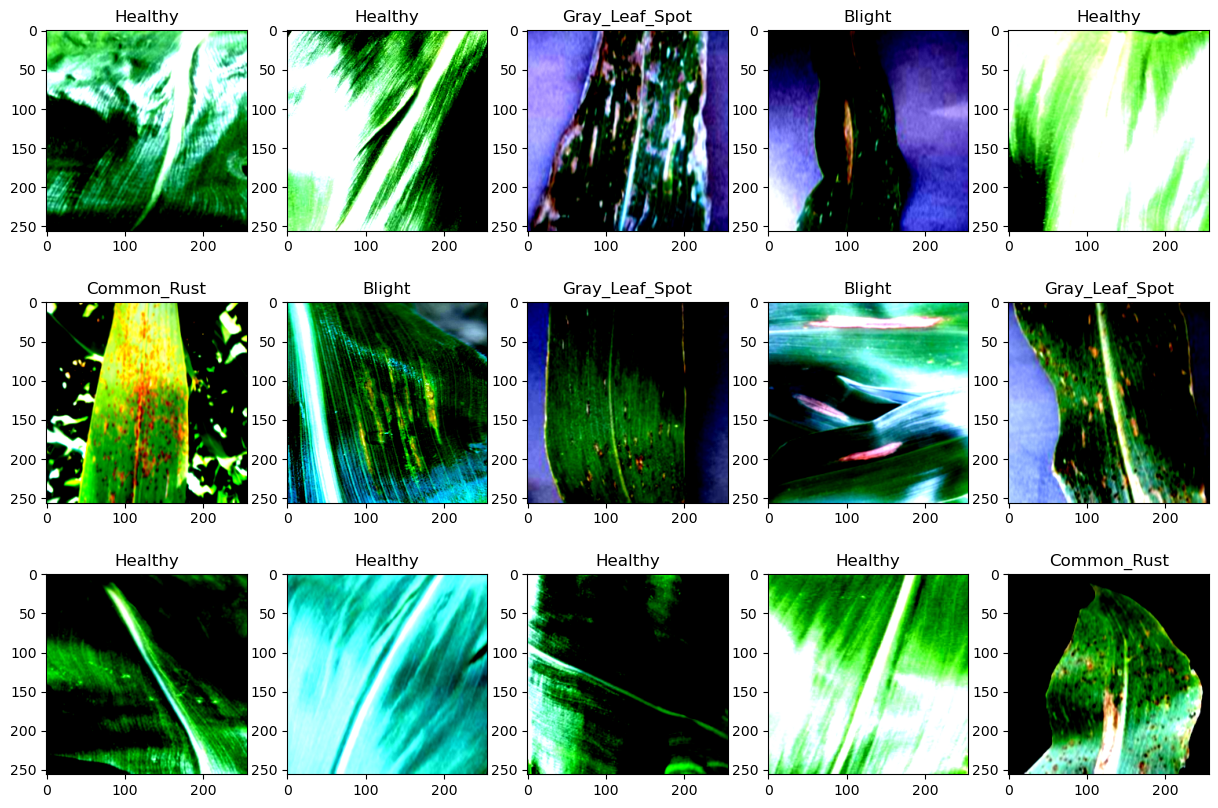

In [10]:
# Plotting the Augmented Images
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(train))
    ax[i].imshow(train[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[train[sample][1]])

In [11]:
train_dataloader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [12]:
# Checking if Images are reshuffled
img, label = next(iter(train_dataloader))
print("Batch and Image Shape:", img.shape, "--> [batch_size, color_channels, height, width]")
print("\nLabels:", label)

Batch and Image Shape: torch.Size([32, 3, 256, 256]) --> [batch_size, color_channels, height, width]

Labels: tensor([3, 1, 2, 3, 0, 2, 3, 3, 0, 1, 3, 0, 0, 2, 0, 1, 2, 2, 0, 0, 3, 2, 1, 3,
        1, 1, 1, 0, 1, 2, 0, 1])


In [13]:
# Deep learning model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

In [14]:
# Code for Transfer Learning
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

In [17]:
# Defining Train and Test Functions
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0
        
        
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            
        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)
        
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)
                
                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()
                
        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)
        
        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model.pth")
            val_best_accuracy = val_accuracy
        
        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [18]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=4)
    model = model.to(device)
    path = "model.pth"
    model.load_state_dict(torch.load(path))
    model.eval()
    
    running_accuracy = 0
    total = 0
    all_predictions = []
    
    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total
            
            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions)

In [19]:
EPOCHS = 15
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...
Completed Epoch:  1 - Training Accuracy: 84 - Validation Accuracy: 92 - Training Loss: 0.4276 - Validation Loss: 0.2004
Completed Epoch:  2 - Training Accuracy: 74 - Validation Accuracy: 82 - Training Loss: 0.6096 - Validation Loss: 0.5606
Completed Epoch:  3 - Training Accuracy: 91 - Validation Accuracy: 92 - Training Loss: 0.2122 - Validation Loss: 0.1882
Completed Epoch:  4 - Training Accuracy: 94 - Validation Accuracy: 94 - Training Loss: 0.1529 - Validation Loss: 0.1453
Completed Epoch:  5 - Training Accuracy: 94 - Validation Accuracy: 94 - Training Loss: 0.1494 - Validation Loss: 0.1756
Completed Epoch:  6 - Training Accuracy: 95 - Validation Accuracy: 95 - Training Loss: 0.1168 - Validation Loss: 0.1181
Completed Epoch:  7 - Training Accuracy: 95 - Validation Accuracy: 96 - Training Loss: 0.1158 - Validation Loss: 0.1118
Completed Epoch:  8 - Training Accuracy: 96 - Validation Accuracy: 96 - Training Loss: 0.0931 - Validation Loss: 0.1022
Completed Epoch:  9 -

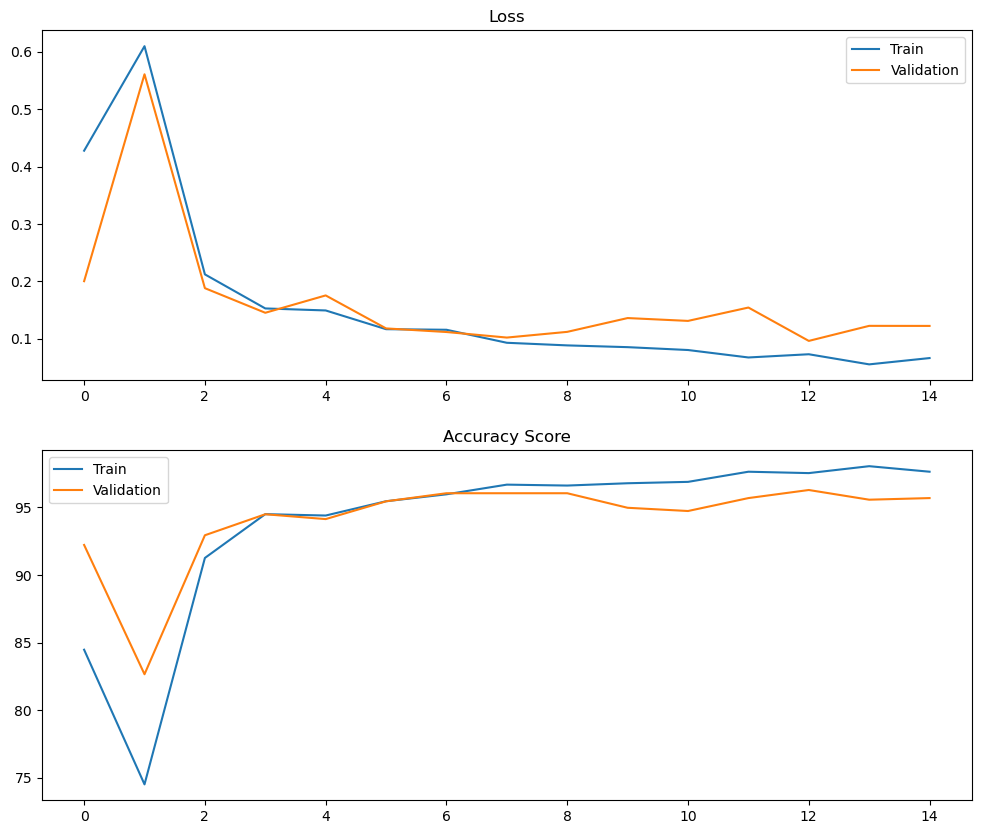

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

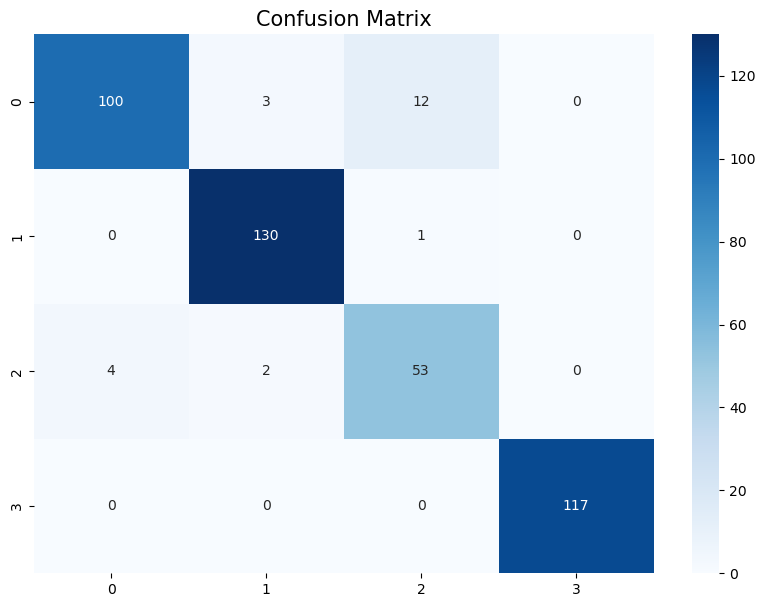

In [22]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

In [21]:
print(classification_report(test.targets, all_preds))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       115
           1       0.96      0.99      0.98       131
           2       0.80      0.90      0.85        59
           3       1.00      1.00      1.00       117

    accuracy                           0.95       422
   macro avg       0.93      0.94      0.93       422
weighted avg       0.95      0.95      0.95       422



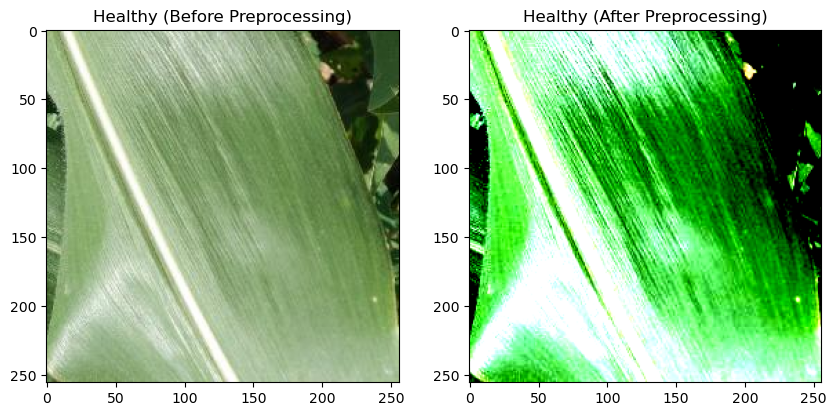

In [23]:
# Testing
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [24]:
single_prediction = model.forward((test[-1][0]).to(device).unsqueeze(0))
single_prediction

tensor([[-4.6522, -2.2578, -2.5715,  6.2778]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [25]:
single_prediction = int(torch.max(single_prediction, 1)[1])
print("Predicted Class:", labels_for_viz[single_prediction])

Predicted Class: Healthy


In [26]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

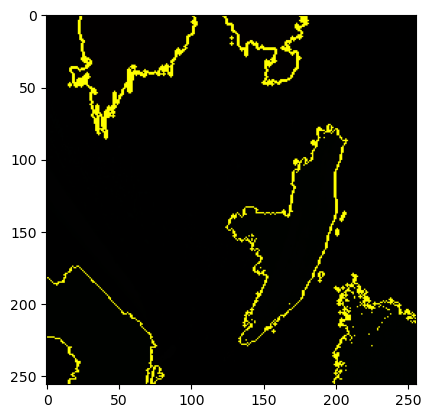

In [27]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def interpret_model(model, image):
    # Define a predict function
    def predict_fn(images):
        model.eval()
        with torch.no_grad():
            images = torch.from_numpy(images).permute(0, 3, 1, 2).to(device).float()
            outputs = model(images)
            return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

    explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0,
                                             num_samples=1000, segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)


image, label = next(iter(test_dataloader))
image = image[0].cpu().numpy().transpose(1,2,0)

# interpret the model with the test image
interpret_model(model, image)


  0%|          | 0/1000 [00:00<?, ?it/s]

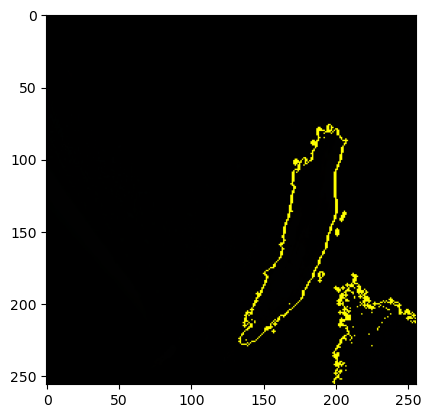

In [28]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    model.eval()
    with torch.no_grad():
        images = torch.from_numpy(images).permute(0, 3, 1, 2).to(device).float()
        outputs = model(images)
        return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

image, label = next(iter(test_dataloader))
image = image[0].cpu().numpy().transpose(1,2,0)

explanation = explainer.explain_instance(image, 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)

plt.imshow(mark_boundaries(temp/255.0, mask))
plt.show()

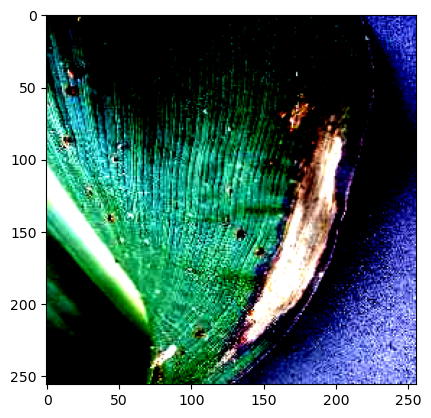

In [29]:
plt.imshow(image)

In [30]:
# Save only the model parameters (state dictionary)
torch.save(model.state_dict(), 'model_state_dict.pth')